In [1]:
import numpy as np
import numpy.random as ra
import xarray as xr
import torch
import matplotlib.pyplot as plt
from pyoptmat import experiments
from maker import make_model
device="cpu"

/home/mark/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters to generate single load history
max_strain = 0.01
tension_hold = 5*60.0
R = -1.0
strain_rate = 1e-3
compression_hold = 1.0e-6
temperature = 500.0
# Number of cycles
N = 50
# Time steps
nload = 20
nhold = 20
scale = 0.1

In [3]:
# Actually generate the data -- can be expensive
times, strains, cycles = experiments.sample_cycle_normalized_times(
    {
        "max_strain": max_strain,
        "R": R,
        "strain_rate": strain_rate,
        "tension_hold": tension_hold,
        "compression_hold": compression_hold
    }, N, nload, nload)
times = torch.tensor(times)
strains = torch.tensor(strains)
temperatures = torch.full_like(times, temperature)
model = make_model(
    torch.tensor(0.5, device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale, size=(3,)), device=device),
    torch.tensor(ra.normal(0.5, scale, size=(3,)), device=device),
    device=device)
with torch.no_grad():
    results = model.solve_strain(times.unsqueeze(-1), strains.unsqueeze(-1), temperatures.unsqueeze(-1))
results = results.squeeze(1)
stress = results[:,0]

In [6]:
# Now actually start playing around with SVDs
keep = 0.75
ntruncate = int(results.shape[0]*keep)
partial_results = results[:ntruncate]

In [9]:
# Start with stress
partial_time = times[:ntruncate]
partial_stress = partial_results[:,0]

In [37]:
# Try some fourier prediction
n = partial_time.shape[0]
X=torch.zeros((len(partial_time),2))
X[:,0] = partial_time
X[:,1] = 1
soln, res, rank, vals = torch.linalg.lstsq(X, partial_stress)
pred = torch.matmul(X,soln)
delinear = partial_stress - pred
x_freq=torch.fft.rfft(delinear)
freq=torch.fft.rfftfreq(x_freq.shape[0])

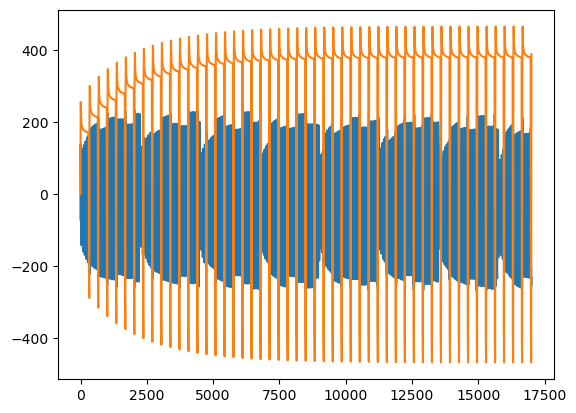

In [58]:
harms = 200
projection=torch.zeros_like(stress)
for h in range(1,harms):
    amp = torch.absolute(x_freq[h])/n
    phase = torch.angle(x_freq[h])
    projection += amp * torch.cos(2.0 * torch.pi * freq[h] * times + phase)
projection += soln[0] * times + soln[1]
plt.plot(times, projection)
plt.plot(times,stress)
